## Gesture recognition

In [35]:
import numpy as np
import cv2
import os
from collections import defaultdict
from matplotlib import pyplot as plt
from skimage.transform import rescale
import imgaug
import imgaug.augmenters as iaa

In [36]:
DATA_PATH = 'gesture_data/'
# GESTURE_TYPES = ['stop', 'ok', 'victory', 'index_finger', 'thumbs_up'] #, 'empty']
GESTURE_TYPES = ['stop', 'victory', 'thumbs_up', 'empty']
NUM_CLASSES = len(GESTURE_TYPES)

In [37]:
gesture_data = defaultdict(list)
for person_dir in os.listdir(DATA_PATH):
    for gest_type in GESTURE_TYPES:
        gest_path_to_images = os.path.join(DATA_PATH, person_dir, gest_type)
        for img_name in os.listdir(gest_path_to_images):
            img_path = os.path.join(gest_path_to_images, img_name)
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            gesture_data[gest_type].append(img)

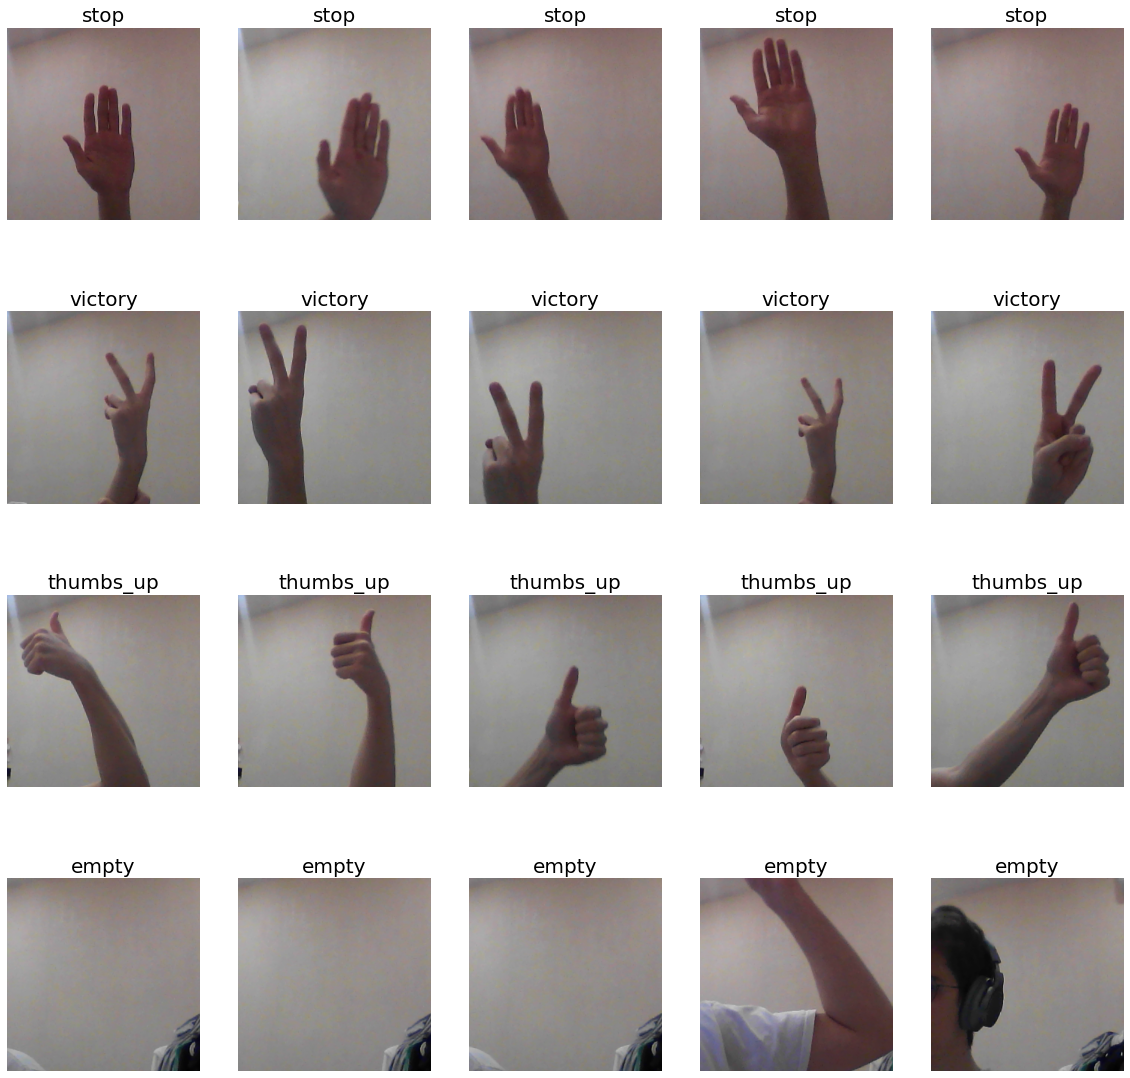

In [94]:
fig, ax = plt.subplots(NUM_CLASSES, 5, figsize=(20, 20))

for i, gest_type in enumerate(GESTURE_TYPES):
    idxs = np.random.choice(len(gesture_data[gest_type]), 5, replace=False)
    for j in range(5):
        ax[i, j].axis('off')
        ax[i, j].set_title(gest_type, fontsize=20)
        ax[i, j].imshow(gesture_data[gest_type][idxs[j]])
        
plt.show()

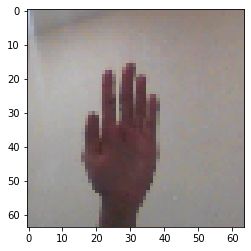

In [39]:
img = gesture_data['stop'][80]
def preprocess_image(img):
    # resize image
    img = cv2.resize(img, (64, 64))
#     gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
#     gray = cv2.GaussianBlur(gray, (5, 5), 3)
#     gray = th3 = cv2.adaptiveThreshold(gray,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,11,2)
#     gray = gray / 255
    return img / 255

plt.imshow(preprocess_image(img), cmap='Greys')
plt.show()

In [40]:
GEST2IND = dict(zip(GESTURE_TYPES, np.arange(len(GESTURE_TYPES))))
IND2GEST = dict(zip(np.arange(len(GESTURE_TYPES)),GESTURE_TYPES))
GEST2IND, IND2GEST

({'stop': 0, 'victory': 1, 'thumbs_up': 2, 'empty': 3},
 {0: 'stop', 1: 'victory', 2: 'thumbs_up', 3: 'empty'})

In [41]:
X = []
y = []

for gest_type in GESTURE_TYPES:
    imgs = gesture_data[gest_type]
    labels = [GEST2IND[gest_type]] * len(imgs)
    prep_imgs = [preprocess_image(img_) for img_ in imgs]
    
    X = X + prep_imgs
    y = y +  labels

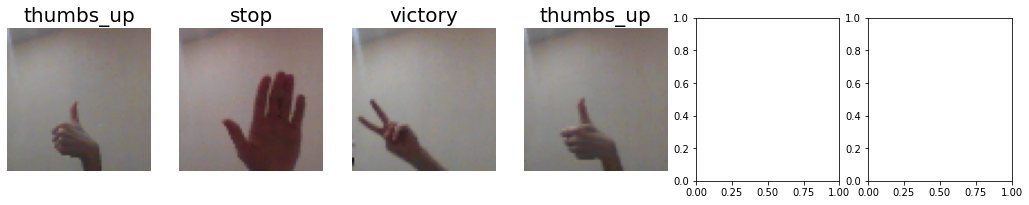

In [42]:
def show_random_images(X, y, n=6):
    fig, ax = plt.subplots(1, n, figsize=(n*3,3))

    idxs = np.random.choice(len(X), n, replace=False)
    for j in range(len(GESTURE_TYPES)):
        ax[j].axis('off')
        ax[j].set_title(IND2GEST[y[idxs[j]]], fontsize=20)
        ax[j].imshow(X[idxs[j]], cmap='Greys')
    plt.show()
    
show_random_images(X, y)

In [43]:
len(X), len(y)

(1904, 1904)

In [44]:
X[0].shape

(64, 64, 3)

(64, 64, 3)


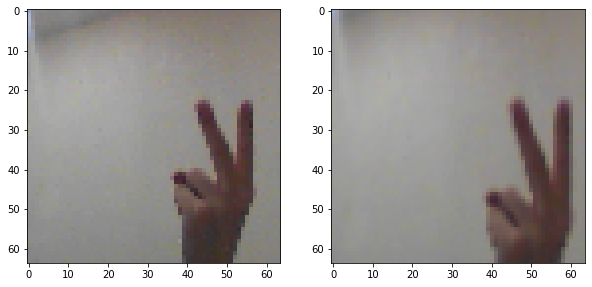

In [45]:
from keras.preprocessing.image import ImageDataGenerator
def augment_image(image):
#     augmentor = iaa.Sequential(
#                 [iaa.Fliplr(0.5)])
# #                  iaa.Affine(scale=(2.0, 2.0), rotate=(-15, 15)),
#                  iaa.Add((-40, 40))])
#                  iaa.AdditiveGaussianNoise(scale=10, per_channel=True)])

    datagen = ImageDataGenerator(width_shift_range=[-2,2],
                                 height_shift_range=[-2, 2],
                                 horizontal_flip=True,
                                 zoom_range=[0.7,1.1])
    image = np.expand_dims(image, 0)
    image = datagen.flow(image, batch_size=1).next()[0]
    
    
#     image = rescale(image, scaleFactor, mode='constant')
#     image = cv2.resize(image,None,fx=scaleFactor, fy=scaleFactor, interpolation = cv2.INTER_CUBIC)
    return image

img = X[np.random.randint(0, len(X))]


aug = augment_image(img)
print(aug.shape)
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(img)
ax[1].imshow(aug)

plt.show()

In [46]:
X_augmented = []
y_augmented = []
for i in range(len(X)):
    cur_img = X[i]
    cur_label = y[i]
    for j in range(2):
        aug_img = augment_image(cur_img)
        X_augmented.append(aug_img)
        y_augmented.append(cur_label)

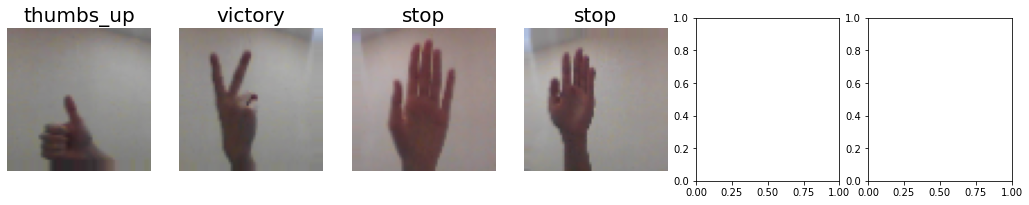

In [47]:
show_random_images(X_augmented, y_augmented)

In [48]:
X = X + X_augmented
y = y + y_augmented

In [49]:
print(X[-1].shape)

(64, 64, 3)


In [50]:
X = np.array(X)
y = np.array(y)

In [51]:
print(X.shape)

(5712, 64, 64, 3)


In [52]:
# X = X[:,:,:,np.newaxis]

In [76]:
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D
from keras.optimizers import SGD,RMSprop,Adam
from keras.utils import np_utils

from keras import backend as K

def get_gesture_model():
    INPUT_SHAPE = (64, 64, 3)
     
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=INPUT_SHAPE))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform'))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(NUM_CLASSES, activation='softmax'))
    # compile model

#     lr_schedule = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=1e-2,
#                                                               decay_steps=10000,
#                                                               decay_rate=0.9)
    opt = Adam(lr=0.01)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

model = get_gesture_model()

In [66]:
test_size = int(0.2 * X.shape[0])
val_size = int(0.1 * X.shape[0])

test_val_ind = np.random.choice(X.shape[0], test_size + val_size, replace=False)
test_ind = test_val_ind
train_ind = sorted(set(np.arange(X.shape[0])) - set(test_val_ind))

val_ind = test_ind[-val_size:]
test_ind = test_ind[:test_size]

X_train = X[train_ind, :, :, :]
y_train = y[train_ind]

X_val = X[val_ind, :, :, :]
y_val = y[val_ind]

X_test = X[test_ind, :, :, :]
y_test = y[test_ind]

In [67]:
def y_to_tensor(y_, num_cl = NUM_CLASSES):
    y_tensors = []
    for el in y_:
        cur_tensor = np.zeros(num_cl)
        cur_tensor[el] = 1.0
        y_tensors.append(cur_tensor)
    return np.array(y_tensors)

In [68]:
y_train = y_to_tensor(y_train)
y_test = y_to_tensor(y_test)
y_val = y_to_tensor(y_val)

In [69]:
print(X_train.shape, X_test.shape, X_val.shape)

(3999, 64, 64, 3) (1142, 64, 64, 3) (571, 64, 64, 3)


In [70]:
print(y_train.shape, y_test.shape, y_val.shape)

(3999, 4) (1142, 4) (571, 4)


'victory'

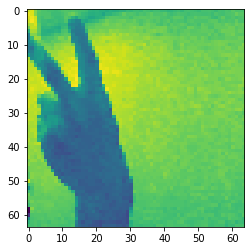

In [71]:
ind = np.random.randint(0, len(X_train))
plt.imshow(X_train[ind, :, :, 0])
IND2GEST[np.argmax(y_train[ind])]

In [60]:
y_train

array([[1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       ...,
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.]])

In [77]:
NUM_TRAIN_IMAGES = X_train.shape[0]
NUM_TEST_IMAGES = X_test.shape[0]
BS = 100
NUM_EPOCHS = 50

In [78]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 62, 62, 32)        896       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 29, 29, 64)        18496     
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 27, 27, 64)        36928     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 13, 13, 64)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 10816)             0         
_________________________________________________________________
dense_6 (Dense)              (None, 100)              

In [74]:
# from keras.utils.data_utils import get_file
# def load_data(path='mnist.npz'):
#     path = get_file(path, origin='https://s3.amazonaws.com/img-datasets/mnist.npz', file_hash='8a61469f7ea1b51cbae51d4f78837e45')
#     with np.load(path, allow_pickle=True) as f:
#         x_train, y_train = f['x_train'], f['y_train']
#         x_test, y_test = f['x_test'], f['y_test']
#     return (x_train, y_train), (x_test, y_test)

# x_tr_, x_te_ = load_data()

# x_train, y_train = x_tr_
# x_test, y_test = x_te_

# x_train = x_train[:,:,:, np.newaxis]
# x_test = x_test[:,:,:, np.newaxis]

# y_train = y_to_tensor(y_train, 10)
# y_test = y_to_tensor(y_test, 10)

In [ ]:
checkpoint = ModelCheckpoint('model-{epoch:03d}-{acc:03f}-{val_acc:03f}.h5', verbose=1, monitor='val_acc',save_best_only=True, mode='auto') 
history = model.fit(
    X_train,
    y_train,
    batch_size=BS,
    epochs=NUM_EPOCHS,
    validation_data=(X_test, y_test),
    callbacks=[checkpoint]
)

In [79]:
checkpoint = ModelCheckpoint('model-{epoch:03d}-{acc:03f}-{val_acc:03f}.h5', verbose=1, monitor='val_acc',save_best_only=True, mode='auto') 
history = model.fit(
    X_train,
    y_train,
    batch_size=BS,
    epochs=NUM_EPOCHS,
    validation_data=(X_test, y_test),
    callbacks=[checkpoint]
)

Epoch 1/50
40/40 [==============================] - 14s 347ms/step - loss: 19.4811 - accuracy: 0.3192 - val_loss: 1.1231 - val_accuracy: 0.5018
Epoch 2/50
40/40 [==============================] - 14s 348ms/step - loss: 1.0096 - accuracy: 0.4925 - val_loss: 0.7292 - val_accuracy: 0.6611
Epoch 3/50
40/40 [==============================] - 14s 358ms/step - loss: 0.8272 - accuracy: 0.5878 - val_loss: 0.8063 - val_accuracy: 0.6296
Epoch 4/50
40/40 [==============================] - 14s 345ms/step - loss: 0.6877 - accuracy: 0.6570 - val_loss: 0.6693 - val_accuracy: 0.6734
Epoch 5/50
40/40 [==============================] - 14s 348ms/step - loss: 0.6380 - accuracy: 0.7117 - val_loss: 0.5237 - val_accuracy: 0.7890
Epoch 6/50
40/40 [==============================] - 14s 359ms/step - loss: 0.4159 - accuracy: 0.8205 - val_loss: 0.3905 - val_accuracy: 0.8485
Epoch 7/50
40/40 [==============================] - 15s 371ms/step - loss: 0.5424 - accuracy: 0.7827 - val_loss: 0.4097 - val_accuracy: 0.843

In [85]:
from keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint('model-{epoch:03d}-{val_accuracy:03f}.h5', verbose=1, monitor='val_accuracy',save_best_only=True, mode='auto') 
history = model.fit(
    X_train,
    y_train,
    batch_size=BS,
    epochs=NUM_EPOCHS,
    validation_data=(X_test, y_test),
    callbacks=[checkpoint]
)

Epoch 1/50
40/40 [==============================] - 13s 337ms/step - loss: 0.1958 - accuracy: 0.9312 - val_loss: 0.3147 - val_accuracy: 0.8862

Epoch 00001: val_accuracy improved from -inf to 0.88616, saving model to model-001-0.886165.h5
Epoch 2/50
40/40 [==============================] - 14s 346ms/step - loss: 0.1923 - accuracy: 0.9310 - val_loss: 0.2656 - val_accuracy: 0.9063

Epoch 00002: val_accuracy improved from 0.88616 to 0.90630, saving model to model-002-0.906305.h5
Epoch 3/50
40/40 [==============================] - 14s 347ms/step - loss: 0.1169 - accuracy: 0.9627 - val_loss: 0.2381 - val_accuracy: 0.9186

Epoch 00003: val_accuracy improved from 0.90630 to 0.91856, saving model to model-003-0.918564.h5
Epoch 4/50
40/40 [==============================] - 15s 364ms/step - loss: 0.0784 - accuracy: 0.9760 - val_loss: 0.3381 - val_accuracy: 0.9054

Epoch 00004: val_accuracy did not improve from 0.91856
Epoch 5/50
40/40 [==============================] - 14s 347ms/step - loss: 0.0


Epoch 00040: val_accuracy did not improve from 0.93433
Epoch 41/50
40/40 [==============================] - 14s 359ms/step - loss: 0.0354 - accuracy: 0.9895 - val_loss: 0.5544 - val_accuracy: 0.8932

Epoch 00041: val_accuracy did not improve from 0.93433
Epoch 42/50
40/40 [==============================] - 14s 339ms/step - loss: 0.0593 - accuracy: 0.9777 - val_loss: 0.7524 - val_accuracy: 0.8748

Epoch 00042: val_accuracy did not improve from 0.93433
Epoch 43/50
40/40 [==============================] - 14s 361ms/step - loss: 0.0358 - accuracy: 0.9890 - val_loss: 0.5772 - val_accuracy: 0.8984

Epoch 00043: val_accuracy did not improve from 0.93433
Epoch 44/50
40/40 [==============================] - 15s 387ms/step - loss: 0.0200 - accuracy: 0.9957 - val_loss: 0.6158 - val_accuracy: 0.8967

Epoch 00044: val_accuracy did not improve from 0.93433
Epoch 45/50
40/40 [==============================] - 17s 424ms/step - loss: 0.1119 - accuracy: 0.9632 - val_loss: 0.5441 - val_accuracy: 0.8835


In [91]:
def draw_pred_5(model, X_test):
    fig, ax = plt.subplots(1, 5, figsize=(15, 3))
    for i in range(5):
        ind = np.random.randint(0, len(X_test), 1)[0]
        pred = model.predict(X_test[ind:ind+1])
        ans = IND2GEST[np.argmax(pred)]
        ax[i].imshow(X_test[ind])
        ax[i].set_title(ans)
        ax[i].axis('off')
    plt.show()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


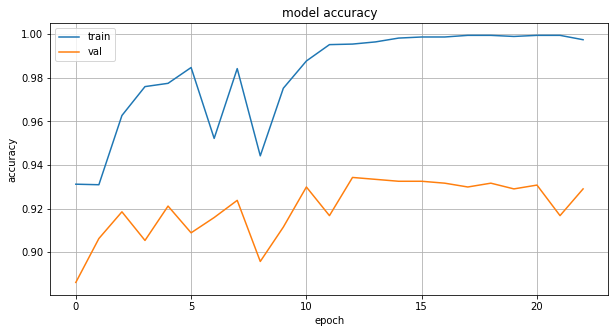

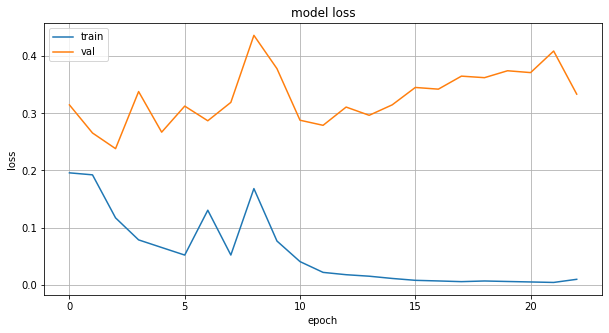

In [112]:
print(history.history.keys())
# summarize history for accuracy
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'][:23])
plt.plot(history.history['val_accuracy'][:23])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.grid(True)
plt.show()
# summarize history for loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'][:23])
plt.plot(history.history['val_loss'][:23])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.grid(True)
plt.show()

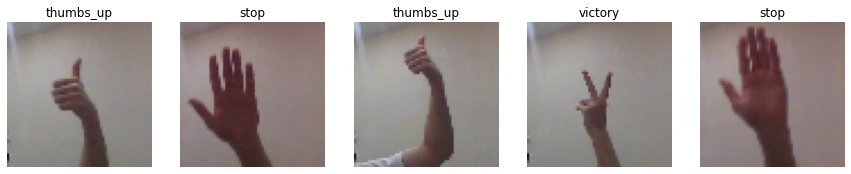

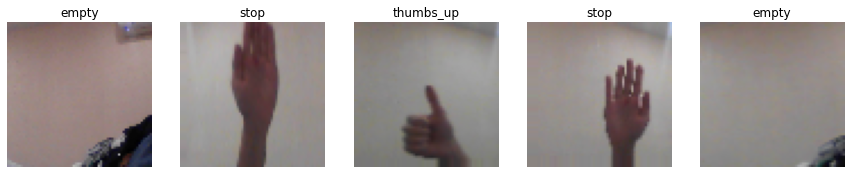

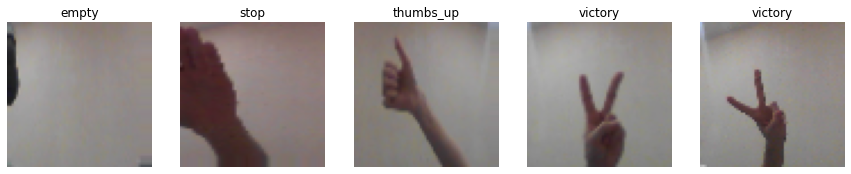

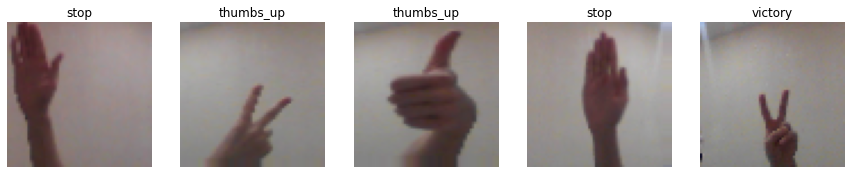

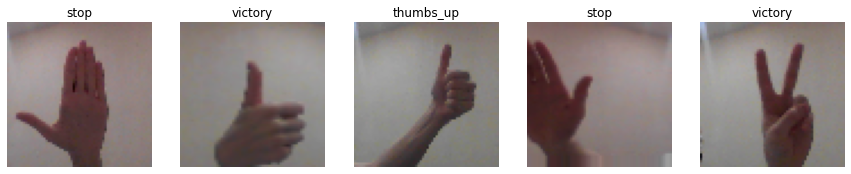

In [93]:
for i in range(5):
    draw_pred_5(model, X_test)